## Deals Centric - 593 Rows

In [28]:
# This version starts with deals as the base table and merges in company and ticket info.
# The final dataset has 593 rows — one per deal, enriched with related company and ticket data.

In [29]:
import pandas as pd
import json
import requests

In [30]:
def load_csv_from_github(file_name):
    base_url = "https://raw.githubusercontent.com/marymorkos/SalesPlaybookDS5640/main/"
    return pd.read_csv(base_url + file_name)

In [31]:
tickets = load_csv_from_github("anonymized_hubspot_tickets.csv")
deals = load_csv_from_github("anonymized_hubspot_deals.csv")
companies = load_csv_from_github("anonymized_hubspot_companies.csv")

/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_18637/3772532305.py:3: DtypeWarning: Columns (24,25,28,32,45) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(base_url + file_name)


In [32]:
import requests

url = "https://raw.githubusercontent.com/marymorkos/SalesPlaybookDS5640/main/mappings.json"
response = requests.get(url)
mappings = json.loads(response.text)

In [33]:
deal_to_company = {}
for company_id, deal_list in mappings["CompanyToDeals"].items():
    for deal_id in deal_list:
        deal_to_company[deal_id] = company_id
deals["Company ID"] = deals["Record ID"].map(deal_to_company)

In [34]:
url = "https://raw.githubusercontent.com/marymorkos/SalesPlaybookDS5640/main/mappings.json"
response = requests.get(url)
mappings = json.loads(response.text)

In [35]:
ticket_to_company = {}
for company_id, ticket_list in mappings["CompanyToTickets"].items():
    for ticket_id in ticket_list:
        ticket_to_company[ticket_id] = company_id
tickets["Company ID"] = tickets["Ticket ID"].map(ticket_to_company)

In [36]:
merged = deals.merge(companies, left_on="Company ID", right_on="Record ID", how="left", suffixes=('', '_company'))

In [37]:
ticket_summary = tickets.groupby("Company ID").agg(lambda x: list(x.dropna()))
merged = merged.merge(ticket_summary, on="Company ID", how="left", suffixes=('', '_tickets'))

In [38]:
merged.columns

Index(['Weighted amount', 'Deal Description',
       'Cumulative time in "BANT Deal. Pain ID'ed (Sales Pipeline)" (HH:mm:ss)',
       'Cumulative time in "Opportunity (Sales Pipeline)" (HH:mm:ss)',
       'Days to close', 'Deal Score', 'Close Date',
       'Deal source attribution 2',
       'Cumulative time in "In Trial - Trial in Progress (Sales Pipeline)" (HH:mm:ss)',
       'Contract Start Date',
       ...
       'Latest Milestone Update Date', 'Ticket name', 'Trial Overview',
       'Trial Start Date', '1st Syms presented for review',
       'Project Launch Day', 'Training: Reporting',
       'Construction of 1st Sym begun', 'Trial Required', 'Was the sym QAed?'],
      dtype='object', length=143)

In [39]:
#merged.to_csv("deals_centric_merged.csv", index=False)
#already ran it 

# **Intro**

This notebook performs exploratory data analysis on a merged HubSpot dataset focused on Deals. It includes data cleaning, feature engineering, and visualization of insights related to deal outcomes.

In [40]:
import pandas as pd
merged = pd.read_csv("/Users/alarakaymak/Desktop/final_merged_dataset.csv")


/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_18637/1271977111.py:2: DtypeWarning: Columns (15,17,26,27,32,34,35,36,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  merged = pd.read_csv("/Users/alarakaymak/Desktop/final_merged_dataset.csv")


In [41]:
# Quick look
merged.head()
merged.info()
merged.describe()
merged.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46847 entries, 0 to 46846
Columns: 143 entries, Create date to Deal Type
dtypes: bool(3), float64(69), int64(2), object(69)
memory usage: 50.2+ MB


Index(['Create date', 'Ticket Tags', 'Stage Date - Project Launch',
       'Associated Contact', 'Category', 'Target Launch Date', 'Kickoff Call',
       'Close date', 'Pipeline', 'Stage Date - Project Initiation',
       ...
       'Cumulative time in "Negotiation (Sales Pipeline)" (HH:mm:ss)',
       'Is Open (numeric)',
       'Cumulative time in "Renewals  (Sales Pipeline)" (HH:mm:ss)',
       'Create Date_deal',
       'Cumulative time in "Contract Sent (Sales Pipeline)" (HH:mm:ss)',
       'Total contract value', 'Last Modified Date_deal',
       'Cumulative time in "Closed Won (Sales Pipeline)" (HH:mm:ss)',
       'Deal Stage', 'Deal Type'],
      dtype='object', length=143)

# Cleaning

- Dropping fully null rows

- Removing columns with >90% missing

- Fixing column types (e.g., converting times and dates)

- Renaming columns for clarity

In [42]:
merged.columns = [col.strip().lower().replace(' ', '_').replace('?', '').replace('"', '').replace("'", "") for col in merged.columns]


In [43]:
# Drop fully empty rows
merged.dropna(how='all', inplace=True)

# Identify columns with >90% missing
high_missing = merged.isnull().mean() > 0.9
dropped_cols = merged.columns[high_missing].tolist()  # Save them before dropping

# Drop them
merged.drop(columns=dropped_cols, inplace=True)

# Print or inspect dropped columns
print("Dropped columns due to high missing values:")
print(dropped_cols)



Dropped columns due to high missing values:
['ticket_tags', 'category', 'stage_date_-_planning_phase', 'last_ces_survey_rating', 'priority', 'who_will_be_creating_the_syms', 'stage_date_-_monitoring_and_control_phase', 'type', 'trial_required', 'was_the_sym_qaed', 'company_id', 'parent_company', 'ccaas', 'annual_revenue', 'target_account', 'associated_contact_company', 'number_of_form_submissions', 'total_agents', 'web_technologies', 'close_date', '#_of_agents_total', 'number_of_times_contacted', 'contact_with_primary_company', 'icp_fit_level', 'revenue_range', '#_of_agents_contracted', 'record_id', 'time_zone', 'primary_industry', 'number_of_pageviews', 'primary_company', 'year_founded', 'icp', 'industry_group', 'segmentation', 'lms_system', 'symtrain_use_cases', 'associated_company_company', 'bpo', 'sso_application', 'state/region', 'symtrain_product', 'contract_end_date', 'sso_implemented', 'consolidated_industry', 'type_company', 'number_of_employees', 'bpo_program', 'primary_sub-i

In [72]:
merged.head()

,stage_date_-_project_launch,associated_contact,target_launch_date,kickoff_call,pipeline,stage_date_-_project_initiation,ticket_status,stage_date_-_execution,time_to_first_agent_email_reply_(hh:mm:ss),associated_company,...,is_open_(numeric),create_date_deal,cumulative_time_in_contract_sent_(sales_pipeline)_(hh:mm:ss),last_modified_date_deal,deal_stage,deal_type,is_won,deal_size_category,sales_cycle_category,create_year_month
0,NaT,Contact_b6d930b5,NaT,2023-12-27,Project Success Plan,2023-12-18,Converted-Won,2024-01-02,NaN,Company_67d87cec,...,1.0,2025-02-20 15:27:00,NaN,2025-02-20 16:28:00,Opportunity,New,False,Small (<$10K),Short (30-89d),2025-02
1,NaT,Contact_b6d930b5,NaT,2023-12-27,Project Success Plan,2023-12-18,Converted-Won,2024-01-02,NaN,Company_67d87cec,...,1.0,2025-02-20 08:07:00,NaN,2025-02-20 09:08:00,Partner Referrals,New,False,Small (<$10K),Medium (90-179d),2025-02
2,NaT,Contact_b6d930b5,NaT,2023-12-27,Project Success Plan,2023-12-18,Converted-Won,2024-01-02,NaN,Company_67d87cec,...,1.0,2025-02-20 08:04:00,NaN,2025-02-20 09:05:00,Partner Referrals,New,False,Small (<$10K),Medium (90-179d),2025-02
3,NaT,Contact_b6d930b5,NaT,2023-12-27,Project Success Plan,2023-12-18,Converted-Won,2024-01-02,NaN,Company_67d87cec,...,1.0,2025-02-20 07:58:00,NaN,2025-02-20 08:59:00,Partner Referrals,New,False,Small (<$10K),Medium (90-179d),2025-02
4,NaT,Contact_b6d930b5,NaT,2023-12-27,Project Success Plan,2023-12-18,Converted-Won,2024-01-02,NaN,Company_67d87cec,...,1.0,2025-02-19 14:02:00,NaN,2025-02-19 15:03:00,Deep Dive. PSP Drafted,New,False,Large ($50K-$100K),Medium (90-179d),2025-02


# **Feature Engineering**

- deal_size_category: Categorizes deals based on weighted_amount

Small (< $10K), Medium (10K–50K), Large (50K–100K), Enterprise (≥ $100K)

- sales_cycle_category: Groups deals by time to close (days_to_close)

Very Short (<30d), Short (30–89d), Medium (90–179d), Long (180–364d), Very Long (365+d)

- total_pipeline_time_sec: combining time across multiple stages

New feature combining time spent in multiple pipeline stages (e.g., BANT, Opportunity, Contract Sent) for a complete view of time in the funnel.

- create_year_month: Extracted from the deal’s creation date for temporal trend analysis

- is_won: A binary indicator based on whether deal_stage == "Closed Won"




In [44]:
# Convert 'true'/'false' strings to actual booleans
for col in ['is_closed_won', 'is_closed_lost']:
    if col in merged.columns:
        merged[col] = merged[col].astype(str).str.lower() == 'true'

# Convert date columns
date_cols = [col for col in merged.columns if 'date' in col]
for col in date_cols:
    merged[col] = pd.to_datetime(merged[col], errors='coerce')


In [45]:
# Create year-month
if 'create_date' in merged.columns:
    merged['create_year_month'] = merged['create_date'].dt.to_period('M')
    merged['create_month'] = merged['create_date'].dt.month
    merged['create_year'] = merged['create_date'].dt.year


In [46]:
# Add is_won from deal stage if needed
if 'deal_stage' in merged.columns:
    merged['is_won'] = merged['deal_stage'] == 'Closed Won'


In [47]:
def categorize_deal_size(amount):
    if pd.isna(amount):
        return "Unknown"
    elif amount < 10000:
        return "Small (<$10K)"
    elif amount < 50000:
        return "Medium ($10K-$50K)"
    elif amount < 100000:
        return "Large ($50K-$100K)"
    else:
        return "Enterprise (>$100K)"

if 'weighted_amount' in merged.columns:
    merged['deal_size_category'] = merged['weighted_amount'].apply(categorize_deal_size)


In [48]:
def categorize_sales_cycle(days):
    if pd.isna(days):
        return "Unknown"
    elif days < 30:
        return "Very Short (<30d)"
    elif days < 90:
        return "Short (30-89d)"
    elif days < 180:
        return "Medium (90-179d)"
    elif days < 365:
        return "Long (180-364d)"
    else:
        return "Very Long (365+d)"

if 'days_to_close' in merged.columns:
    merged['sales_cycle_category'] = merged['days_to_close'].apply(categorize_sales_cycle)


In [49]:
time_cols = ['secs_bant', 'secs_opportunity', 'secs_trial', 'secs_deep_dive', 'secs_renewals']
available_cols = [col for col in time_cols if col in merged.columns]
if available_cols:
    merged['total_pipeline_time_sec'] = merged[available_cols].sum(axis=1, skipna=True)


In [51]:
merged['original_traffic_source'] = merged['original_traffic_source'].fillna('Unknown')
merged['original_traffic_source'] 

0        Offline Sources
1        Offline Sources
2        Offline Sources
3        Offline Sources
4        Offline Sources
              ...       
46842    Offline Sources
46843    Offline Sources
46844    Offline Sources
46845    Offline Sources
46846    Offline Sources
Name: original_traffic_source, Length: 46847, dtype: object

# Visualizations

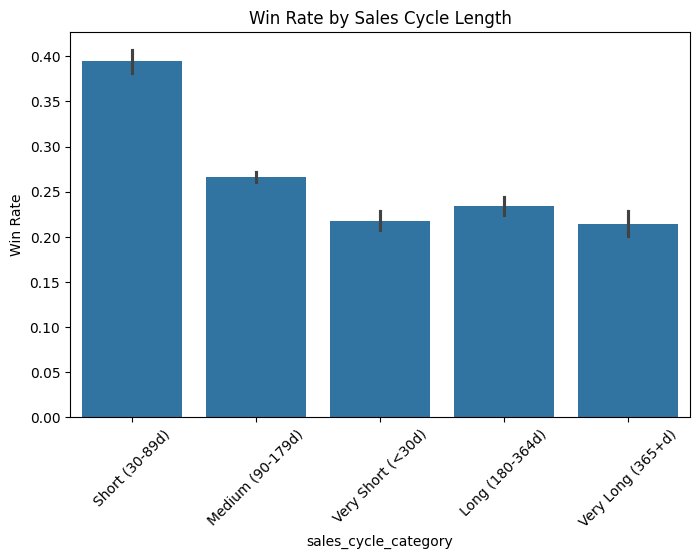

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(data=merged, x='sales_cycle_category', y='is_won')
plt.title("Win Rate by Sales Cycle Length")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.show()


Deals with shorter sales cycles (30–89 days) are much more likely to succeed than those with long or very long cycles.
- Long sales cycles may be indicative of stalled or struggling deals.

In [53]:
print(merged.columns.tolist())


['stage_date_-_project_launch', 'associated_contact', 'target_launch_date', 'kickoff_call', 'pipeline', 'stage_date_-_project_initiation', 'ticket_status', 'stage_date_-_execution', 'time_to_first_agent_email_reply_(hh:mm:ss)', 'associated_company', 'stage_date_-_closure_phase', 'associated_company_(primary)', 'response_time_(hh:mm:ss)', 'ticket_id', 'time_to_close_(hh:mm:ss)', 'associated_deal', 'library_index_approved', 'training:_general_overview', 'latest_milestone', 'training:_deployment/user_management_training', 'requirements_for_the_trial', 'training:_sym_building_101', 'trial_end_date', 'training:_sym_building_201', 'stage_date_-_converted_won', 'latest_milestone_update_date', 'ticket_name', 'trial_overview', '1st_syms_presented_for_review', 'project_launch_day', 'training:_reporting', 'construction_of_1st_sym_begun', 'weighted_amount', 'deal_description', 'cumulative_time_in_bant_deal._pain_ided_(sales_pipeline)_(hh:mm:ss)', 'days_to_close', 'deal_score', 'close_date_deal', '

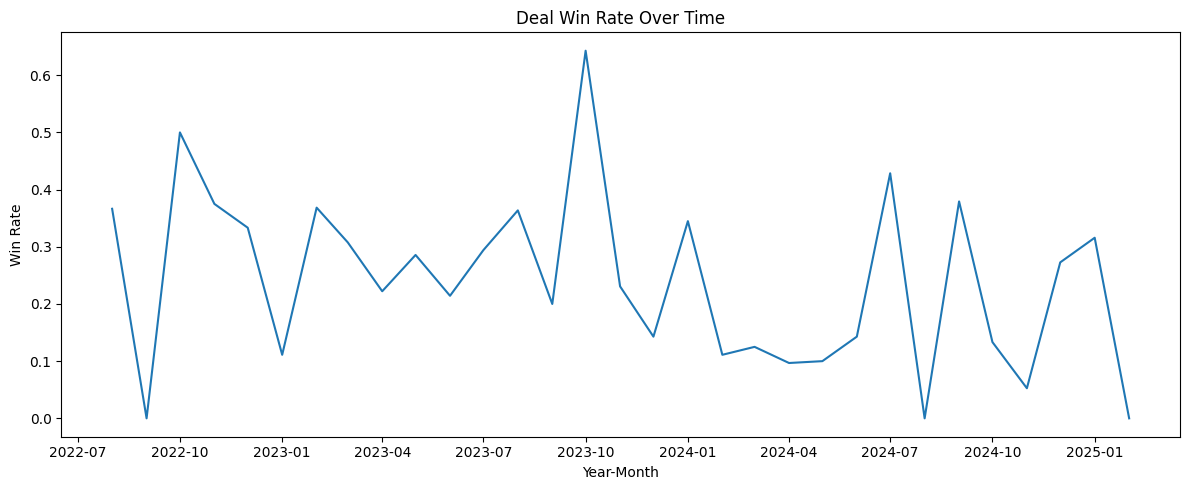

In [54]:
# Convert to datetime and extract year-month
merged['create_date_deal'] = pd.to_datetime(merged['create_date_deal'], errors='coerce')
merged['create_year_month'] = merged['create_date_deal'].dt.to_period('M')

# Optional: Create is_won again if needed
merged['is_won'] = merged['deal_stage'] == 'Closed Won'

# Now plot win rate over time
if 'create_year_month' in merged.columns:
    monthly_wins = merged.groupby('create_year_month')['is_won'].mean().reset_index()
    monthly_wins['create_year_month'] = monthly_wins['create_year_month'].dt.to_timestamp()

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=monthly_wins, x='create_year_month', y='is_won')
    plt.title("Deal Win Rate Over Time")
    plt.xlabel("Year-Month")
    plt.ylabel("Win Rate")
    plt.tight_layout()
    plt.show()


Win rates fluctuate monthly with no obvious trend, showing some instability across time.
- Could be seasonal or impacted by external sales force or campaign activities.

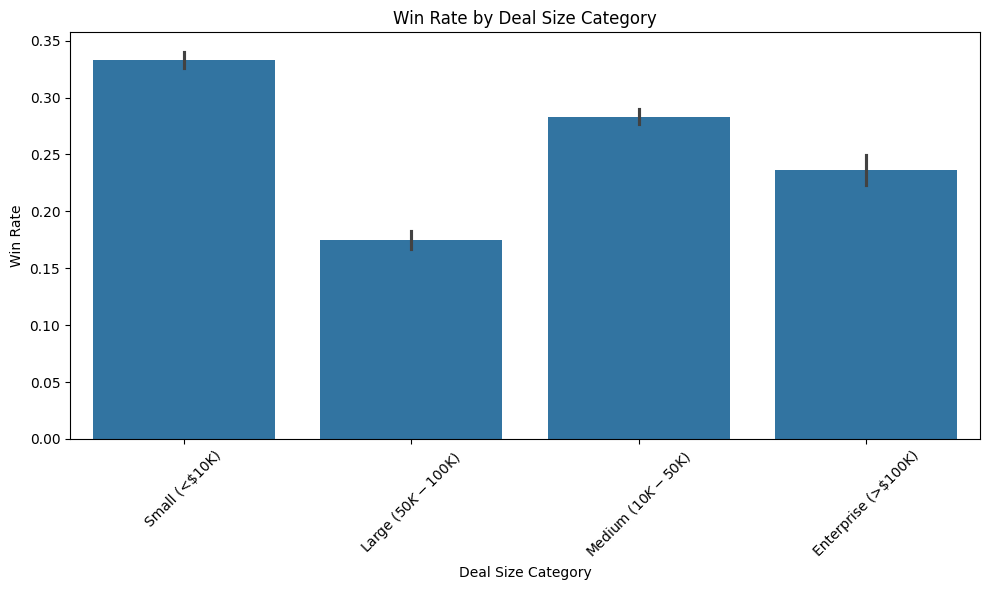

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out 'Unknown' before plotting
filtered = merged[merged['deal_size_category'] != 'Unknown']

# Plot win rate by deal size
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered, x='deal_size_category', y='is_won')
plt.title('Win Rate by Deal Size Category')
plt.xlabel('Deal Size Category')
plt.ylabel('Win Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The bar chart shows that smaller deals (<$10K) have the highest win rate (~33%), with a generally decreasing trend as deal size increases, though Enterprise deals perform slightly better than Large deals.

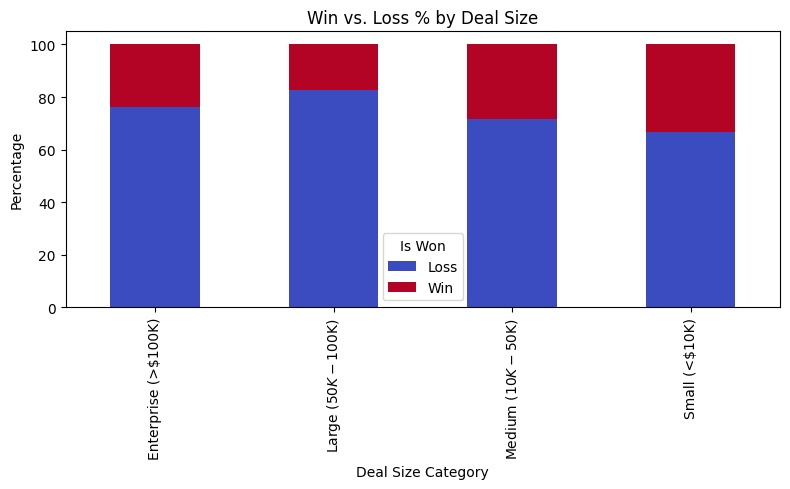

In [67]:
# Filter out "Unknown" deal size category
filtered = merged[merged['deal_size_category'] != "Unknown"]

# Create crosstab of win/loss % by deal size
cross = pd.crosstab(filtered['deal_size_category'], filtered['is_won'], normalize='index') * 100

# Plot stacked bar chart
cross.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='coolwarm')
plt.title("Win vs. Loss % by Deal Size")
plt.xlabel("Deal Size Category")
plt.ylabel("Percentage")
plt.legend(title='Is Won', labels=['Loss', 'Win'])
plt.tight_layout()
plt.show()


The stacked bar chart shows the proportion of won versus lost deals for each size category.It reinforces the idea that while small deals have a red (win) section of approximately 30-35%, Large deals ($50K-$100K) show the smallest win proportion at around 15-20%. The chart clearly illustrates that as deal size increases from Small to Large, the blue section (representing losses) grows, though Enterprise deals perform slightly better than Large deals. This visualization effectively communicates the win/loss distribution across different deal sizes, reinforcing the challenge of closing larger opportunities..

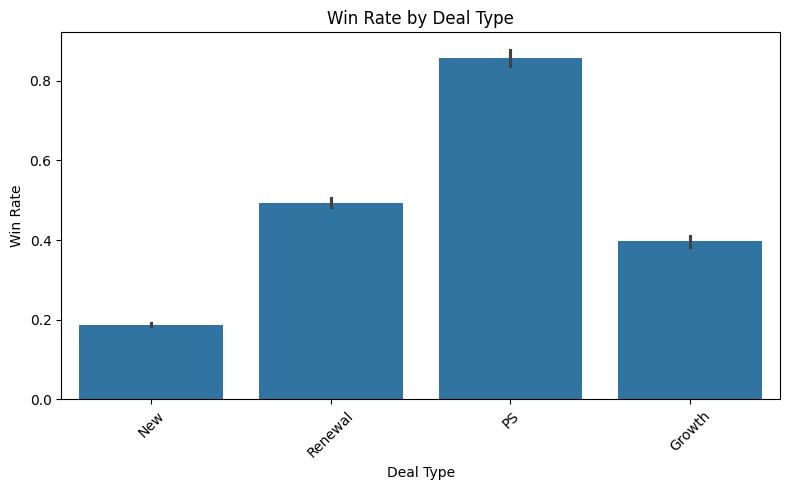

In [56]:
plt.figure(figsize=(8, 5))
sns.barplot(data=merged, x='deal_type', y='is_won')
plt.title("Win Rate by Deal Type")
plt.xlabel("Deal Type")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Professional Services (PS) deals and Renewals are far more likely to close than New or Growth deals.
- Sales teams may benefit from prioritizing renewals or PS opportunities.

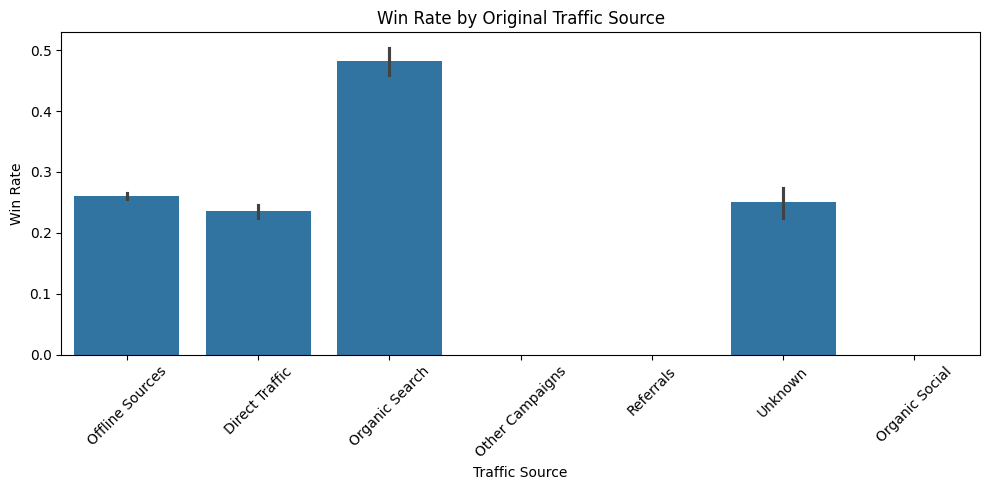

In [57]:
plt.figure(figsize=(10, 5))
sns.barplot(data=merged, x='original_traffic_source', y='is_won')
plt.title("Win Rate by Original Traffic Source")
plt.xlabel("Traffic Source")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Organic Search performs best in terms of win rate (~48%), while Direct Traffic and Referrals show lower performance.
- This indicates the value of SEO and search-based inbound leads. 

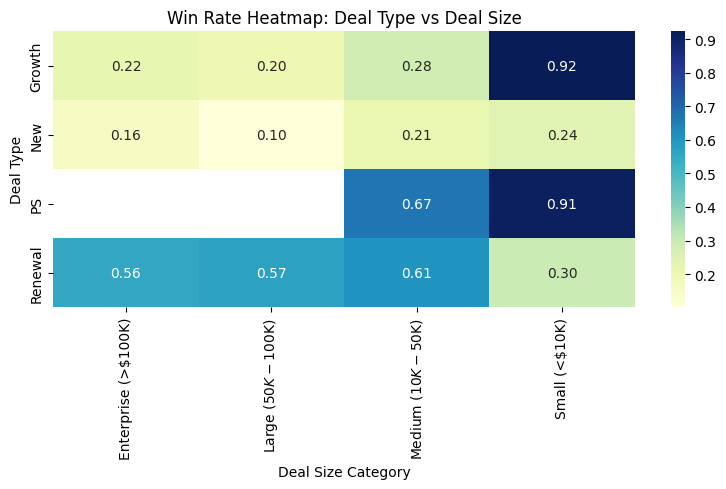

In [68]:
heat_data = merged.pivot_table(
    index='deal_type',
    columns='deal_size_category',
    values='is_won',
    aggfunc='mean'
)

# Drop the "Unknown" column if it exists
heat_data = heat_data.drop(columns='Unknown', errors='ignore')

plt.figure(figsize=(8, 5))
sns.heatmap(heat_data, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title("Win Rate Heatmap: Deal Type vs Deal Size")
plt.xlabel("Deal Size Category")
plt.ylabel("Deal Type")
plt.tight_layout()
plt.show()


This heatmap shows win rates by deal type and deal size.

- PS (Professional Services) and Growth deals have very high win rates for Small deals (both ~91–92%).

- Renewals perform consistently well across all sizes, especially for Medium to Large deals.

- New deals have the lowest win rates overall, especially for larger deal sizes.

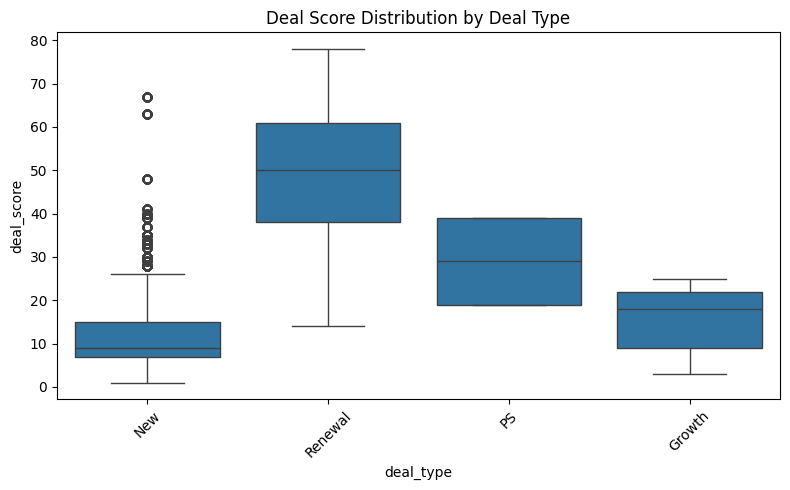

In [61]:
if 'deal_score' in merged.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=merged[merged['deal_score'].notna()], x='deal_type', y='deal_score')
    plt.title("Deal Score Distribution by Deal Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


The plot shows that Renewal deals have the highest and most varied deal scores, suggesting strong confidence in those deals. New deals have the lowest scores with many outliers, indicating uncertainty. PS and Growth deals fall in between. Overall, deal score reflects expected success, especially for open deals.

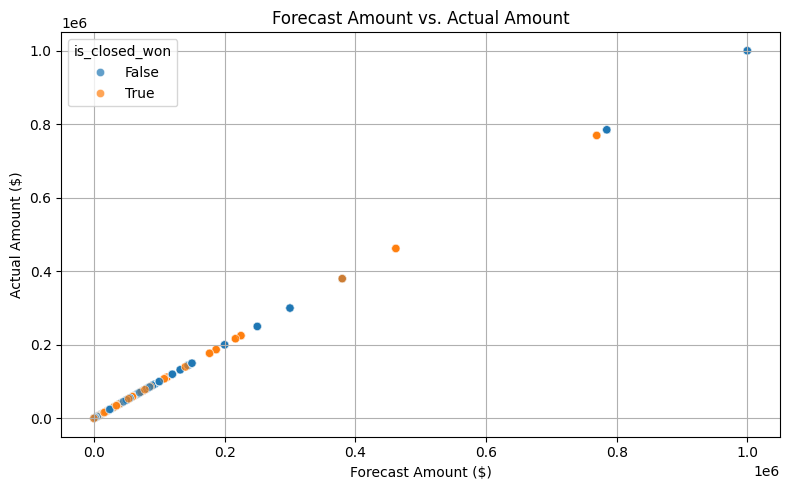

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Forecast Amount vs. Actual Amount (Scatter)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged, x='forecast_amount', y='amount', hue='is_closed_won', alpha=0.7)
plt.title("Forecast Amount vs. Actual Amount")
plt.xlabel("Forecast Amount ($)")
plt.ylabel("Actual Amount ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


The scatter plot reveals a strong correlation between forecasted and actual deal amounts. Both closed-won and lost deals generally align along the diagonal, indicating that sales teams accurately estimate deal values regardless of the outcome. This suggests that forecast_amount is a reliable variable for modeling and forecasting purposes.

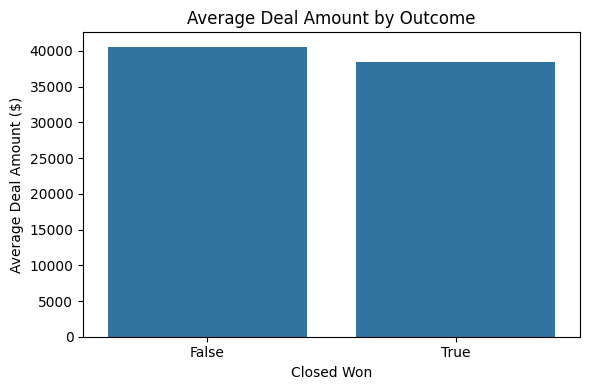

In [70]:

# Average Amount by Deal Outcome (Bar Chart)
avg_amount = merged.groupby('is_closed_won')['amount'].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_amount, x='is_closed_won', y='amount')
plt.title("Average Deal Amount by Outcome")
plt.xlabel("Closed Won")
plt.ylabel("Average Deal Amount ($)")
plt.tight_layout()
plt.show()


Deals that were lost tend to have a higher average amount than those that were won, suggesting that larger deals are harder to close successfully.

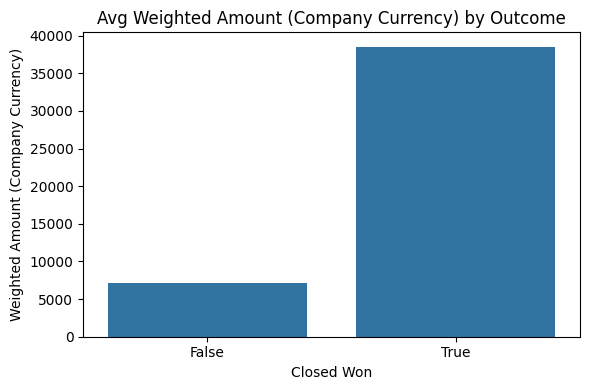

In [71]:

# Weighted Amount in Company Currency by Outcome (Bar Chart)
avg_weighted = merged.groupby('is_closed_won')['weighted_amount_in_company_currency'].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_weighted, x='is_closed_won', y='weighted_amount_in_company_currency')
plt.title("Avg Weighted Amount (Company Currency) by Outcome")
plt.xlabel("Closed Won")
plt.ylabel("Weighted Amount (Company Currency)")
plt.tight_layout()
plt.show()



The average weighted amount is significantly higher for Closed Won deals compared to lost ones. This means when deals are won, they tend to be more valuable—suggesting a strong payoff when successful

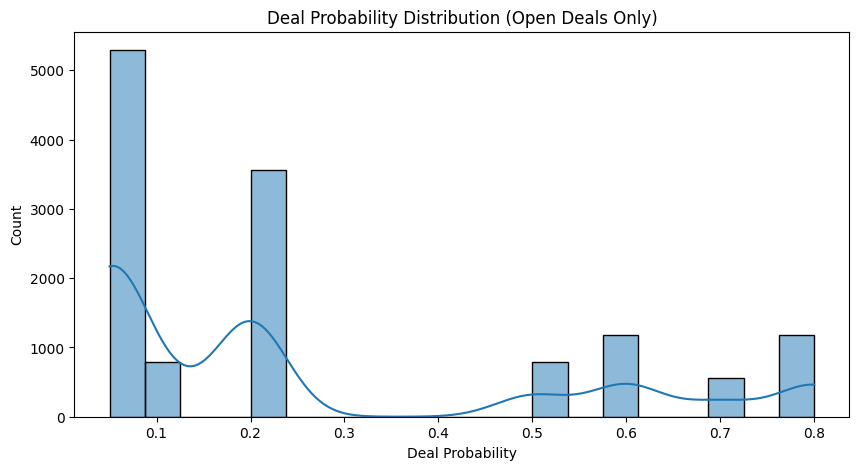

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only open deals
open_deals = merged[merged['is_deal_closed'] == False]

# Drop NaNs just in case
open_deals = open_deals.dropna(subset=['deal_probability'])

# Plot distribution of deal_probability for open deals
plt.figure(figsize=(10,5))
sns.histplot(data=open_deals, x='deal_probability', bins=20, kde=True)
plt.title('Deal Probability Distribution (Open Deals Only)')
plt.xlabel('Deal Probability')
plt.ylabel('Count')
plt.show()


This chart shows that most open deals have a low deal probability, clustering around 10–20%. Only a smaller portion of deals are assigned higher probabilities, such as 50% or above. This suggests that the current pipeline is filled with low-confidence opportunities, which may lead to inefficiencies in the sales process. It also highlights a potential need for better qualification of leads or more accurate probability scoring. Focusing efforts on high-probability deals could improve overall win rates and resource allocation.

# **Conclusion**

This exploratory data analysis revealed key patterns behind deal success. Smaller deals (under $10K) tend to win more often, while enterprise deals—though harder to close—bring higher value. Shorter sales cycles (30–89 days) correlate with higher win rates, highlighting the impact of speed on conversions. Among deal types, Professional Services and Renewals perform best, likely benefiting from existing relationships. While Offline Sources drive the most deals, Organic Search shows stronger win performance. Forecasted and actual amounts align well, suggesting reliable internal projections. Finally, engineered features like deal_size_category, sales_cycle_category, and is_won were crucial in uncovering these trends and will serve as strong foundations for future modeling and decision-making.